In [1]:
import pickle
from copy import deepcopy

# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats
import statsmodels.api as sm
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# Genres_all_all = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror',
#                   'Documentary', 'Crime', '(no genres listed)', 'Adventure', 'Sci-Fi', 
#                   'Children', 'Animation', 'Mystery', 'Fantasy', 'War', 'Western', 
#                   'Musical', 'Film-Noir', 'IMAX']
Genres_all_all = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror',
                  'Documentary', 'Crime', 'Adventure', 'Sci-Fi', 
                  'Children', 'Animation', 'Mystery', 'Fantasy', 'War', 'Western', 
                  'Musical', 'Film-Noir']

Genres_all = ['Action', 'Comedy', 'Adventure', 'Thriller', 'Drama', 
          'Children', 'Crime', 'Horror', 'Sci-Fi', 'Animation']

def format_plot(ax, legend_outside = False, legend = True):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_color('dimgrey')
    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.grid(color = 'k', linestyle = '-', linewidth = 1, alpha = 0.2)
    
    if legend:
        if legend_outside:
            ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
        else:
            plt.legend()

# Load in datasets

In [3]:
# path = "movielens_data/ml-25m/"
# ratings_data_25 = pd.read_csv(path+'ratings.csv')
# movies_data_25 = pd.read_csv(path+'movies.csv')

In [4]:
# path = "movielens_data/ml-100k/"
# ratings_header = ['userId', 'movie_id', 'rating', 'timestamp']
# ratings_data = pd.read_csv(path + 'u.data', sep='\t', names=ratings_header)

# movies_header = ['movie_id', 'title' ,'release_date','video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure',
# 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
# 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# movies_data = pd.read_csv(path + 'u.item', sep='|', names=movies_header, encoding='latin-1')
# movies_data = movies_data.drop(['release_date', 'video_release_date', 'IMDb_URL'], axis = 1)

# users_header = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
# users_data = pd.read_csv(path + 'u.user', sep='|', names=users_header,encoding='latin-1')

# Match movie ids between two datasets by title

In [5]:
# ratings_data['movieId'] = pd.Series([-1 for x in range(len(ratings_data.index))], index=ratings_data.index)
# old_id_to_new_id = {}
# not_found = []
# for idx, row in movies_data.iterrows():
#     movie_title = row['title']
#     old_movie_id = row['movie_id']
#     new_movies = movies_data_25[movies_data_25['title'] == movie_title]
#     if len(new_movies) > 0:
#         new_movie_id = list(new_movies['movieId'])[0]
#         ratings_data.loc[ratings_data.movie_id == old_movie_id, 'movieId'] = new_movie_id
#         old_id_to_new_id[old_movie_id] = new_movie_id
#     else:
#         not_found.append((old_movie_id, movie_title))

In [6]:
# print(f"Movies in 100K dataset not matched to 25M dataset: {len(not_found)}")

In [7]:
# movies_ratings_data = movies_data.merge(ratings_data, on = 'movie_id', how = 'inner')

In [8]:
# print(f"Number of ratings that have an unmatched movie: {sum(movies_ratings_data['movieId'] == -1)}")

In [9]:
# with open('movielens_data/movies_ratings_data.pkl', 'wb') as f:
#     pickle.dump(movies_ratings_data, f)

# Load in Preprocessed movie to max genre dictionaries

In [10]:
with open('movielens_data/movies_ratings_data.pkl', 'rb') as f:
    movies_ratings_data = pickle.load(f)

with open('movielens_data/movie_max_genres.pkl', 'rb') as f:
    movie_max_genres = pickle.load(f)

with open('movielens_data/movie_max_genres_relevances.pkl', 'rb') as f:
    movie_max_genres_relevances = pickle.load(f)

# Set Parameter

In [11]:
w = 3
d = 5
d2 = 2
Genres = Genres_all

In [12]:
users_list = list(set(movies_ratings_data['userId']))

# Get Genres, Max Movies, and time gaps between ratings

In [13]:
very_last_timestamp = 893286638
user_movie_genres = {}
user_movie_max_genres = {}
user_movie_ratings = {}
user_in_between_ratings_times = {}
all_in_between_ratings_times = []
time_since_last_ratings = []
max_in_between_ratings_times = []
for user in tqdm(users_list):
    ratings_user = movies_ratings_data[movies_ratings_data['userId'] == user].sort_values(by = 'timestamp') # Ratings of this user
    
    
    user_movie_ratings[user] = ratings_user['rating'].to_numpy()
    user_movie_genres[user] = []
    user_movie_max_genres[user] = []
    user_movie_timestamps = list(ratings_user['timestamp'])
    last_timestamp = user_movie_timestamps[0]
    time_since_last_ratings.append((very_last_timestamp - user_movie_timestamps[-1])/(60.*60.*24.))
    time_gaps = []               
    for idx, row in ratings_user.iterrows():
        genres = []
        
        curr_timestamp = row['timestamp']
        time_gaps.append((curr_timestamp - last_timestamp)/(60.*60.*24.))
        last_timestamp = curr_timestamp
        
        for genre in Genres_all_all:
            if row[genre] == 1:
                genres.append(genre)
        if  len(genres) == 0:
            genres.append("None")

        movieId = row['movieId']
        if movieId > -1:
            max_genre = movie_max_genres[movieId]
        else:
            max_genre = genres[0]
        user_movie_genres[user].append(genres)
        user_movie_max_genres[user].append(max_genre)
    max_in_between_ratings_times.append(np.max(time_gaps))
    user_in_between_ratings_times[user] = deepcopy(time_gaps)
    all_in_between_ratings_times.extend(time_gaps)

  0%|          | 0/943 [00:00<?, ?it/s]

In [14]:
genre_data = {genre: {"recencies": [], "variabilities": [], "ratings": []} for genre in Genres_all_all + ["None"]}
for user in tqdm(users_list):
    u_genres = user_movie_genres[user]
    u_max_genres = user_movie_max_genres[user]
    u_ratings = user_movie_ratings[user]
    
    total_items = len(user_movie_genres[user])
    for i in range(w, total_items):
        curr_rating = u_ratings[i]
        curr_genres = u_genres[i]
        curr_variability = len(set(u_max_genres[i-w+1:i+1])) #variability in this movie and last w-1 movies watched
        
        for genre in curr_genres:
            genre_data[genre]['ratings'].append(curr_rating)
            genre_data[genre]['variabilities'].append(curr_variability)
            
            current_recency = 0. # Initialize recency for the current movie genre
            for j in range(1,w+1): # Look at the last w (or i if there is not enough history) movies watched
                if genre in u_genres[i-j]:# If j time steps before, user has watched a movie of the genre genre
                    current_recency += 1 / j  # ... Then the recency is updated
            genre_data[genre]['recencies'].append(current_recency)  # Update recencies of the user for genre

  0%|          | 0/943 [00:00<?, ?it/s]

# Examine Data:

In [15]:
smooth_window = 2
genres_vals_per_recency = {}
for genre in tqdm(Genres):
    genre_recencies = np.array(genre_data[genre]["recencies"])
    genre_ratings = np.array(genre_data[genre]["ratings"])
    
    unique_recencies = list(set(genre_recencies))
    unique_recencies.sort()
    
    recency_means = []
    recency_stds = []

    l_unique_recencies = len(unique_recencies)
    for i in range(smooth_window, l_unique_recencies - smooth_window):
        window_range = range(i-smooth_window, i+smooth_window + 1)
        recency_ratings = []
        for j in window_range:
            recency = unique_recencies[j]
            recency_ratings.extend(genre_ratings[genre_recencies == recency])

        recency_means.append(np.mean(recency_ratings))
        recency_stds.append(np.std(recency_ratings))
        genres_vals_per_recency[genre] = {'recencies': unique_recencies[smooth_window: l_unique_recencies - smooth_window], 'recency_means': recency_means, 'recency_stds': recency_stds}
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
#Variability
n = 5

user_variability = {}
user_ratings = {}
all_variability = []
all_ratings = []

for user in tqdm(users_list):
    user_movies_ratings_data = movies_ratings_data[movies_ratings_data['userId'] == user].sort_values(by = ['timestamp'], ascending = True)
    user_movie_max_genre = user_movie_max_genres[user]
    user_variability[user] = [len(set(user_movie_max_genre[i:i+n])) for i in range(len(user_movie_max_genre) - n)]
    all_variability.extend(user_variability[user])
    
    ratings = list(user_movies_ratings_data['rating'])
    user_ratings[user] = ratings[n:]
    all_ratings.extend(ratings[n:])

  0%|          | 0/943 [00:00<?, ?it/s]

In [17]:
all_variability = np.array(all_variability)
all_ratings = np.array(all_ratings)

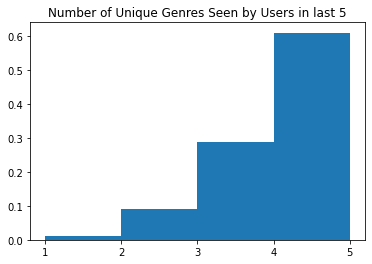

In [18]:
plt.hist(all_variability, density = True, bins = range(1,n+1))
plt.xticks(range(1, n+1))
plt.title(f'Number of Unique Genres Seen by Users in last {n}')
plt.show()

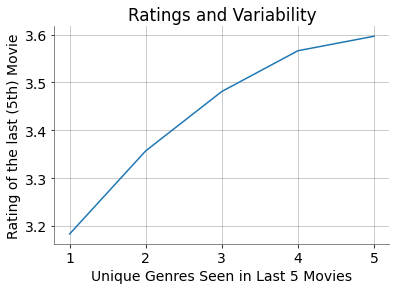

In [19]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.figure()
ax = plt.subplot(111)
avg_variability_ratings = []
variability_stds = []
for i in range(1, n+1):
    avg_variability_ratings.append(np.mean(all_ratings[all_variability == i]))
    variability_stds.append(np.std(all_ratings[all_variability == i]))
    
t = np.arange(1, n+1)
avg_variability_ratings = np.array(avg_variability_ratings)
variability_stds = np.array(variability_stds)
plt.plot(t, avg_variability_ratings)
plt.xlabel(f'Unique Genres Seen in Last {n} Movies')
plt.ylabel(f'Rating of the last ({n}th) Movie')
# plt.title(f'Ratings and Variability, History = {n}')
plt.title(f'Ratings and Variability')
# p = np.poly1d(np.polyfit(t, avg_variability_ratings, 3))
# plt.plot(np.arange(1, n, 0.1), p(np.arange(1, n, 0.1)))
# plt.errorbar(range(1, n+1), avg_variability_ratings, yerr = variability_stds/2)
format_plot(ax, legend = False)

plt.show()


In [20]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(all_ratings, all_variability)
slope, p_value

(0.05426233782275823, 2.4867856469063414e-92)

### Make Train Test Set

In [21]:
d1 = 2
d2 = 2
genres_X = {genre: None for genre in Genres}
for genre in tqdm(Genres):
    genre_recencies = np.array(genre_data[genre]["recencies"])
    genre_recencies2 = np.array(genre_data[genre]["recencies"])
    genre_recencies2[genre_recencies2 == 0] = -1
    genre_variabilities = genre_data[genre]['variabilities']
    n_points = len(genre_recencies)
    X = np.array([[genre_recencies[i] ** j for j in range(d + 1)] +[(genre_variabilities[i]/float(w))**j for j in range(1, d1+1)]+ [(genre_variabilities[i]/float(w) * genre_recencies2[i])**j for j in range(1, d2+1)] for i in range(n_points)])
#     X = np.array([[genre_recencies[i] ** j for j in range(d + 1)] + [(genre_variabilities[i]/float(w) * genre_recencies[i])**j for j in range(1, d2+1)] for i in range(n_points)])


    X_train, X_test, y_train, y_test = train_test_split(X, genre_data[genre]["ratings"], test_size = 0.2)
    genres_X[genre] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

  0%|          | 0/10 [00:00<?, ?it/s]

### Fit Models

In [22]:
genre_results = {}
reg_novar_coef = {}
reg_var_coef = {}
reg_novar_coef_arr = []
reg_var_coef_arr = []

for genre in tqdm(Genres):
    X_train = genres_X[genre]['X_train']
    X_test = genres_X[genre]['X_test']
    y_train = genres_X[genre]['y_train']
    y_test = genres_X[genre]['y_test']
    
    reg_novar = LinearRegression(fit_intercept=False).fit(X_train[:, 0:6], y_train)
    preds_novar_train = reg_novar.predict(X_train[:, 0:6])
    preds_novar_test = reg_novar.predict(X_test[:, 0:6])
    r2_novar_train = reg_novar.score(X_train[:, 0:6], y_train)
    r2_novar_test = reg_novar.score(X_test[:, 0:6], y_test)
    mse_novar_train = mean_squared_error(preds_novar_train, y_train)
    mse_novar_test = mean_squared_error(preds_novar_test, y_test)
    
    reg_var = LinearRegression(fit_intercept=False).fit(X_train, y_train)
    preds_var_train = reg_var.predict(X_train)
    preds_var_test = reg_var.predict(X_test)
    r2_var_train = reg_var.score(X_train, y_train)
    r2_var_test = reg_var.score(X_test, y_test)
    mse_var_train = mean_squared_error(preds_var_train, y_train)
    mse_var_test = mean_squared_error(preds_var_test, y_test)
    genre_results[genre] = (r2_novar_train, r2_novar_test, mse_novar_train, mse_novar_test, r2_var_train, r2_var_test, mse_var_train, mse_var_test)
    
    reg_novar_coef[genre] = reg_novar.coef_
    reg_novar_coef_arr.append(reg_novar.coef_)
    reg_var_coef[genre] = reg_var.coef_
    reg_var_coef_arr.append(reg_var.coef_)
    
    print(genre)
    print("Old model: ", r2_novar_train, r2_novar_test, mse_novar_train, mse_novar_test)
    print("New model: ", r2_var_train, r2_var_test, mse_var_train, mse_var_test)
    print()
reg_novar_coef_arr = np.array(reg_novar_coef_arr) 
reg_var_coef_arr = np.array(reg_var_coef_arr)

  0%|          | 0/10 [00:00<?, ?it/s]

Action
Old model:  0.0040407416340696445 0.003493752160423247 1.2603515701714836 1.2713475736122037
New model:  0.00797845032396216 0.008384492820216916 1.255368537694506 1.2651079426169387

Comedy
Old model:  0.007103082367531766 0.007418135299826489 1.290495659430676 1.3216990534879827
New model:  0.009628399982000269 0.011671994037343425 1.2872134340936026 1.3160347135811217

Adventure
Old model:  0.00044530678708054605 -0.0006251428400758652 1.2561936437008063 1.3399285377778376
New model:  0.005893211667590714 0.004043194487098112 1.2493469713487555 1.3336772073436456

Thriller
Old model:  0.0027638032305157267 -0.0008727529345169405 1.228088765735943 1.2224627115925997
New model:  0.006490377506878087 -0.00028584907485784683 1.2234995179546182 1.2217458691352348

Drama
Old model:  0.0030582317669913817 0.001979002667761187 1.1642467225534996 1.149191706718466
New model:  0.0042926379657822755 0.0026990116172596057 1.1628051605515493 1.1483626376750906

Children
Old model:  0.0032

### Parameters Used Ratings:

In [23]:
reg_var_coef_arr

array([[ 3.47056208e+00, -2.68368473e-01, -2.00701885e+00,
         4.04673784e+00, -2.68976180e+00,  5.82511337e-01,
         3.45454739e-01, -1.40220384e-01,  1.93838775e-01,
         2.36415252e-02],
       [ 3.15685721e+00, -4.65855236e-01,  1.91870392e+00,
        -3.30044876e+00,  2.20370061e+00, -5.12195637e-01,
         8.22511583e-01, -5.43726538e-01,  2.91859020e-02,
         9.25619168e-02],
       [ 2.83704255e+00, -1.23029162e+00,  3.63740233e+00,
        -4.66073334e+00,  2.46578530e+00, -4.49803651e-01,
         1.70884464e+00, -8.79825837e-01,  1.36099801e-01,
         3.51808854e-03],
       [ 3.02220610e+00, -3.79154969e-02, -7.53940064e-01,
         1.60237032e+00, -1.16582601e+00,  2.73727996e-01,
         1.02643385e+00, -4.64329495e-01,  1.35543720e-02,
         2.16492065e-02],
       [ 3.00296489e+00,  2.03311690e+00, -4.40584545e+00,
         4.99289637e+00, -2.63381764e+00,  5.12119206e-01,
         7.07830577e-01, -3.06926555e-01, -1.82722084e-01,
         2.

# Dropout

### Find Dropout Users (Users that haven't used the system for more than n days)

In [24]:
all_in_between_ratings_times = np.array(all_in_between_ratings_times)
time_since_last_ratings = np.array(time_since_last_ratings)
max_in_between_ratings_times = np.array(max_in_between_ratings_times)

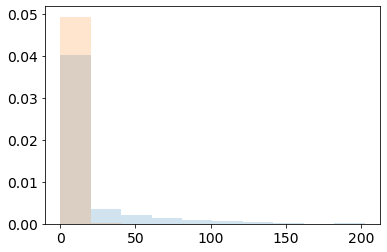

In [25]:
plt.hist(max_in_between_ratings_times, alpha = 0.2, density = True)
plt.hist(all_in_between_ratings_times, alpha = 0.2, density = True)
plt.show()

In [26]:
np.quantile(time_since_last_ratings, [0.25, 0.5, 0.75, 0.95])

array([ 26.09821181,  95.03256944, 155.16755787, 194.21957407])

In [27]:
np.quantile(all_in_between_ratings_times, [0.25, 0.5, 0.75, 0.99])

array([0.00000000e+00, 0.00000000e+00, 4.16666667e-04, 3.59736979e+00])

In [28]:
n = 20
users_more_n = np.array(users_list)[time_since_last_ratings > n]
print(sum(max_in_between_ratings_times > n))
print(sum(time_since_last_ratings > n))
print(sum(max_in_between_ratings_times > n)/(sum(max_in_between_ratings_times > n) + sum(time_since_last_ratings > n)))

177
813
0.1787878787878788


In [29]:
#Variability
n = 5
r_b = 3.5

all_variability_dropout = []
all_but_last_variability = []
last_variability = []

all_ratings = []
all_avg_ratings = []
all_but_last_avg_ratings = []
last_avg_ratings = []

all_percent_ratings = []
all_but_last_percent_ratings = []
last_percent_ratings = []

genre_all_variability_dropout = {genre:[] for genre in Genres_all_all}
genre_all_but_last_variability = {genre:[] for genre in Genres_all_all}
genre_last_variability = {genre:[] for genre in Genres_all_all}

for user in tqdm(users_more_n):
    user_movies_ratings_data = movies_ratings_data[movies_ratings_data['userId'] == user].sort_values(by = ['timestamp'], ascending = True)
    user_movie_max_genre = user_movie_max_genres[user]
    user_variability_vals = [len(set(user_movie_max_genre[i:i+n])) for i in range(len(user_movie_max_genre) - n)]
    
    
    all_variability_dropout.extend(user_variability_vals)
    all_but_last_variability.extend(user_variability_vals[0:-1])
    last_variability.append(user_variability_vals[-1])
    
    ratings = list(user_movies_ratings_data['rating'])
    all_ratings.extend(ratings[n:])
    
    user_avg_rating = [np.mean(ratings[i:i+n]) for i in range(len(ratings) - n)]
    all_avg_ratings.extend(user_avg_rating)
    all_but_last_avg_ratings.extend(user_avg_rating[0:-1])
    last_avg_ratings.append(user_avg_rating[-1])
    
    user_percent_rating = [np.mean(np.array(ratings[i:i+n]) < r_b) for i in range(len(ratings) - n)]
    all_percent_ratings.extend(user_percent_rating)
    all_but_last_percent_ratings.extend(user_percent_rating[0:-1])
    last_percent_ratings.append(user_percent_rating[-1])
    
    for idx, max_genre in enumerate(user_movie_max_genre[n:]):
        if max_genre in Genres_all_all:
            genre_all_variability_dropout[max_genre].append(user_variability_vals[idx])
            if idx == len(user_movie_max_genre[n:]) - 1:
                genre_last_variability[max_genre].append(user_variability_vals[idx])
            else:
                genre_all_but_last_variability[max_genre].append(user_variability_vals[idx])
        

  0%|          | 0/813 [00:00<?, ?it/s]

In [30]:
all_but_last_variability = np.array(all_but_last_variability)
last_variability = np.array(last_variability)
all_variability= np.array(all_variability_dropout)

all_but_last_avg_ratings = np.array(all_but_last_avg_ratings)
last_avg_ratings = np.array(last_avg_ratings)
all_avg_ratings = np.array(all_avg_ratings)

all_but_last_percent_ratings = np.array(all_but_last_percent_ratings)
last_percent_ratings = np.array(last_percent_ratings)
all_percent_ratings = np.array(all_percent_ratings)

for max_genre in Genres_all_all:
    genre_all_variability_dropout[max_genre] = np.array(genre_all_variability_dropout[max_genre])
    genre_last_variability[max_genre] = np.array(genre_last_variability[max_genre])
    genre_all_but_last_variability[max_genre] = np.array(genre_all_but_last_variability[max_genre])

### Variability and Dropout

In [31]:
print(np.mean(all_variability))
print(np.mean(all_but_last_variability))
print(np.mean(last_variability))

3.702695486162103
3.7034012687272235
3.6383763837638377


In [32]:
dropout_p = []
conf_p = []
var_x = range(1, n+1)
for i in var_x:
    p_i = np.sum(last_variability == i)/np.sum(all_variability == i)
    n_i = np.sum(all_variability == i)
    dropout_p.append(p_i)
    conf_p.append(1.96*np.sqrt((p_i)*(1-p_i)/n_i))
dropout_p = np.array(dropout_p)
conf_p = np.array(conf_p)

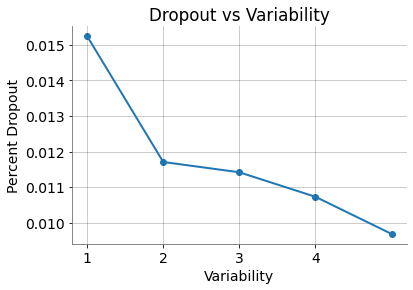

In [33]:
plt.figure()
ax = plt.subplot(111)

# plt.plot(var_x[0:-1], dropout_p[0:-1], linewidth=2)
# plt.scatter(var_x[0:-1], dropout_p[0:-1])

plt.plot(var_x, dropout_p, linewidth=2)
plt.scatter(var_x, dropout_p)
# plt.fill_between(var_x, (dropout_p-conf_p), (dropout_p+conf_p), color = 'C0', alpha=.2)
plt.xticks(var_x[0:-1])
plt.xlabel('Variability')
plt.ylabel('Percent Dropout')
plt.title('Dropout vs Variability')

format_plot(ax, legend = False)

plt.show()

#### Hypothesis Tests

In [34]:
dropout_p_all = np.hstack([all_but_last_variability, last_variability])
var_x_all = np.hstack([np.zeros(len(all_but_last_variability)), np.ones(len(last_variability))])

In [35]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dropout_p_all, var_x_all)
print(slope)
print(intercept)
print(p_value)

-0.0008139716240624508
0.013867926947283183
0.04647016573817672


In [36]:
i1 = 1
i2 = 5
obs = np.array([[np.sum(last_variability == i1), np.sum(last_variability == i2)], [np.sum(all_variability == i1), np.sum(all_variability == i2)]])
print(obs)
teststat, pvalue, degfree, expectedvals = scipy.stats.chi2_contingency(obs)
print(teststat, pvalue)

[[   13   146]
 [  853 15075]]
1.9366229438278932 0.16403567919381729


### Dropout vs variability

In [37]:
dropout_p

array([0.01524033, 0.01170644, 0.01141712, 0.01072829, 0.00968491])

In [38]:
X = []
y = []

for idx, max_genre in enumerate(Genres_all_all):
    all_variability = genre_all_variability_dropout[max_genre]
    last_variability = genre_last_variability[max_genre]
    all_but_last_variability =  genre_all_but_last_variability[max_genre]
    n_features = len(var_x) + len(Genres_all_all)
    
    
    for var in last_variability:
        x = np.zeros(n_features)
        x[var-1] = 1
        x[len(var_x) + idx] = 1
        X.append(x)
        y.append(1)
    
    for var in all_but_last_variability:
        x = np.zeros(n_features)
        x[var-1] = 1
        x[len(var_x)+idx] = 1
        X.append(x)
        y.append(0)

In [39]:
mod = sm.OLS(y,X)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']

In [40]:
dropout_var_act = []
for genre in Genres:
    g_idx = Genres_all_all.index(genre)
    dropout_var = [1]
    for v in var_x:
        dropout_var.append(fii.params[v-1] + fii.params[len(var_x) + g_idx])
    dropout_var_act.append(dropout_var)        

### Parameters Used Dropout:

In [41]:
dropout_var_act

[[1,
  0.016880341732725707,
  0.013447872411128426,
  0.0132060180845463,
  0.012483519177897324,
  0.011505679265467026],
 [1,
  0.01610839784729058,
  0.0126759285256933,
  0.012434074199111175,
  0.011711575292462199,
  0.0107337353800319],
 [1,
  0.011792130357078387,
  0.008359661035481105,
  0.008117806708898981,
  0.007395307802250004,
  0.006417467889819705],
 [1,
  0.014098559704213386,
  0.010666090382616105,
  0.01042423605603398,
  0.009701737149385003,
  0.008723897236954705],
 [1,
  0.014467032966370079,
  0.011034563644772797,
  0.010792709318190673,
  0.010070210411541696,
  0.009092370499111397],
 [1,
  0.01854137622827951,
  0.015108906906682228,
  0.014867052580100105,
  0.014144553673451129,
  0.01316671376102083],
 [1,
  0.015303615974718278,
  0.011871146653120997,
  0.011629292326538872,
  0.010906793419889895,
  0.009928953507459598],
 [1,
  0.019133806258447607,
  0.015701336936850326,
  0.015459482610268202,
  0.014736983703619226,
  0.013759143791188928],
 [